In [23]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [14, 6]
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from biosppy.signals import ecg
#
from hrv.classical import time_domain
from hrv.classical import frequency_domain
from hrv.classical import non_linear
from sklearn.preprocessing import MinMaxScaler, StandardScaler
attributes = ['ANN', 'SDNN', 'SDSD', 'NN50', 'pNN50', 'NN20', 'pNN20', 'rMSSD', 'MedianNN']

In [24]:
def timeDomain(NN):
    
    L = len(NN)    
    ANN = np.mean(NN)
    SDNN = np.std(NN)
    SDSD = np.std(np.diff(NN))    
    NN50 = len(np.where(np.diff(NN) > 0.05)[0])    
    pNN50 = NN50/L    
    NN20 = len(np.where(np.diff(NN) > 0.02)[0])
    pNN20 = NN20/L
    rMSSD = np.sqrt((1/L) * sum(np.diff(NN) ** 2))        
    MedianNN = np.median(NN)
    
    timeDomainFeats = {'ANN': ANN, 'SDNN': SDNN,
                       'SDSD': SDSD,
                       'pNN50': pNN50}
                       
    return timeDomainFeats

def cal_r_peaks(signal, sampling_rate):
    """
    """
    rpeaks, = ecg.hamilton_segmenter(signal=signal,
                                     sampling_rate=sampling_rate)
    rpeaks, = ecg.correct_rpeaks(signal=signal,
                                 rpeaks=rpeaks,
                                 sampling_rate=sampling_rate,
                                 tol=0.05)
    templates, rpeaks = ecg.extract_heartbeats(signal=signal,
                                               rpeaks=rpeaks,
                                               sampling_rate=sampling_rate,
                                               before=0.2,
                                               after=0.4)
    return rpeaks

def create_features(raw_data, fs):
    """
    """
    data  = raw_data[:, :-1]
    label = raw_data[:, -1]

    result = []
    for x in data:
        rpeaks = cal_r_peaks(x, fs)
        tmp = rpeaks[1:] - rpeaks[:-1]
        rri = tmp / fs

        time = timeDomain(rri)
    #     time = time_domain(rri)
        result.append(list(time.values()))
    result = np.array(result)
    return result, label

In [25]:
training = np.load('training.npy')
testing  = np.load('test.npy')
evaluate = np.load('more_interpolation.npy')
print(training.shape)
print(testing.shape)
print(evaluate.shape)

training_features, training_label = create_features(training, 360)
testing_features, testing_label = create_features(testing, 360)
evaluate_features, evaluate_label = create_features(evaluate, 360)

scaler = StandardScaler()
scaler.fit(training_features)
scaled_training_features = scaler.transform(training_features)
#
scaler.fit(testing_features)
scaled_testing_features = scaler.transform(testing_features)
#
scaler.fit(evaluate_features)
scaled_evaluate_features = scaler.transform(evaluate_features)

print(scaled_training_features.shape)
print(scaled_testing_features.shape)
print(scaled_evaluate_features.shape)

(3214, 10801)
(541, 10801)
(529, 10801)
(3214, 4)
(541, 4)
(529, 4)


In [32]:
model = MLPClassifier(solver='adam', alpha=1e-10, hidden_layer_sizes=((10, 10,10)), random_state=1, learning_rate_init=.01)
model.fit(X=scaled_training_features, y=training_label)

prediction1 = model.predict(scaled_testing_features)
acc1 = accuracy_score(prediction1, testing_label)
print("the result of test1: ")
print(acc1)

prediction = model.predict(scaled_evaluate_features)
acc = accuracy_score(prediction, evaluate_label)
print("the result of test2: ")
print(acc)

the result of test1: 
0.9205175600739371
the result of test2: 
0.9376181474480151


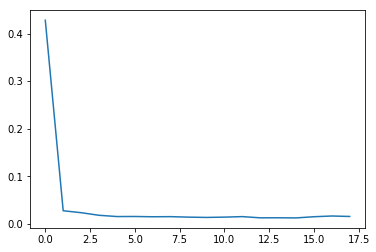

In [30]:
plt.plot(model.loss_curve_)

In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testing_label, prediction1)
#confusion_matrix(evaluate_label, prediction)

array([[149,  19],
       [ 23, 350]])

In [7]:
a = scaled_testing_features[0:5]
b = testing_label[0:5]
print(model.predict_proba(a))
print(model.predict(a))

[[9.71411899e-05 9.99902859e-01]
 [1.50230915e-02 9.84976909e-01]
 [9.99795805e-01 2.04195345e-04]
 [9.99999980e-01 2.03149253e-08]
 [1.00000000e+00 3.91673268e-11]]
[1. 1. 0. 0. 0.]
